<a href="https://colab.research.google.com/github/harshmjain114/fed-meeting-stock-correlation/blob/main/Fed_Meeting_and_Stock_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download and load the Whisper ML Model

In [57]:
!pip install git+https://github.com/openai/whisper.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [58]:
import whisper

model = whisper.load_model("base")

In [59]:
# Check if Google Colab is using the GPU
model.device

device(type='cuda', index=0)

Download pytube to get the audio of the fed meeting

In [60]:
!pip install pytube -q
from pytube import YouTube

In [62]:
youtube_video_url = "https://www.youtube.com/watch?v=NT2H9iyd-ms"
youtube_video = YouTube(youtube_video_url)

In [65]:
youtube_video.title
#dir(youtube_video)

'WATCH LIVE | Fed Chair Powell Discusses Latest Fed Rate Hike'

In [66]:
for stream in youtube_video.streams:
   print(stream)

<Stream: itag="17" mime_type="video/3gpp" res="144p" fps="7fps" vcodec="mp4v.20.3" acodec="mp4a.40.2" progressive="True" type="video">
<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">
<Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">
<Stream: itag="137" mime_type="video/mp4" res="1080p" fps="30fps" vcodec="avc1.640028" progressive="False" type="video">
<Stream: itag="248" mime_type="video/webm" res="1080p" fps="30fps" vcodec="vp9" progressive="False" type="video">
<Stream: itag="136" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001f" progressive="False" type="video">
<Stream: itag="247" mime_type="video/webm" res="720p" fps="30fps" vcodec="vp9" progressive="False" type="video">
<Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d401f" progressive="False" type="video">
<St

Get the first audio stream, and trim out the necessary part

In [67]:
streams = youtube_video.streams.filter(only_audio=True)
stream = streams.first()
stream

<Stream: itag="139" mime_type="audio/mp4" abr="48kbps" acodec="mp4a.40.5" progressive="False" type="audio">

In [68]:
stream.download(filename="fed_meeting.mp4")

'/content/fed_meeting.mp4'

In [70]:
!ffmpeg -ss 378 -i fed_meeting.mp4 -t 2715 fed_meeting_trimmed.mp4

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Transcribe it using the Whisper Model

In [83]:
output = model.transcribe("fed_meeting_trimmed.mp4")

In [87]:
output["text"][0:350]

' Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2% goal. We have both the tools that we need and the resolve it will take to restore price stability on behalf of American families and businesses. Price stability is the responsibility of the Federal Reserve and serves as the bedrock of our economy. '

Divide the transcription into 5 second blocks

In [88]:
for segment in output["segments"]:
  second = int(segment['start'])
  second = second - (second % 5)

Read the SPY data, in 5 second blocks, during the fed meeting. Match the speech in the blocks using datetime

In [73]:
import pandas as pd

In [74]:
spy = pd.read_csv("spy.csv")

In [75]:
spy

,date,open,high,low,close,volume,average,barCount
0,2022-11-02 14:31:15,387.13,387.17,386.75,386.83,82173.0,386.884,444
1,2022-11-02 14:31:20,386.80,387.00,386.80,386.91,38918.0,386.913,234
2,2022-11-02 14:31:25,386.94,386.96,386.55,386.64,48165.0,386.749,232
3,2022-11-02 14:31:30,386.64,386.95,386.59,386.86,30688.0,386.760,190
4,2022-11-02 14:31:35,386.91,386.92,386.81,386.87,22270.0,386.862,130
...,...,...,...,...,...,...,...,...
538,2022-11-02 15:16:05,380.30,380.48,380.30,380.39,40401.0,380.418,265
539,2022-11-02 15:16:10,380.37,380.49,380.24,380.45,40709.0,380.378,221
540,2022-11-02 15:16:15,380.45,380.48,380.38,380.39,12465.0,380.425,69
541,2022-11-02 15:16:20,380.38,380.38,380.28,380.36,24107.0,380.324,139


In [76]:
for segment in output['segments']:
  second = int(segment['start'])
  second = second - (second % 5)
  spy.loc[second / 5, 'text'] = segment['text']
  
spy

,date,open,high,low,close,volume,average,barCount,text
0,2022-11-02 14:31:15,387.13,387.17,386.75,386.83,82173.0,386.884,444,Good afternoon. My colleagues and I are stron...
1,2022-11-02 14:31:20,386.80,387.00,386.80,386.91,38918.0,386.913,234,We have both the tools that we need and the r...
2,2022-11-02 14:31:25,386.94,386.96,386.55,386.64,48165.0,386.749,232,NaN
3,2022-11-02 14:31:30,386.64,386.95,386.59,386.86,30688.0,386.760,190,Price stability is the responsibility of the ...
4,2022-11-02 14:31:35,386.91,386.92,386.81,386.87,22270.0,386.862,130,"Without price stability, the economy does not..."
...,...,...,...,...,...,...,...,...,...
538,2022-11-02 15:16:05,380.30,380.48,380.30,380.39,40401.0,380.418,265,but it's not to the extent we had hoped. At t...
539,2022-11-02 15:16:10,380.37,380.49,380.24,380.45,40709.0,380.378,221,NaN
540,2022-11-02 15:16:15,380.45,380.48,380.38,380.39,12465.0,380.425,69,NaN
541,2022-11-02 15:16:20,380.38,380.38,380.28,380.36,24107.0,380.324,139,That means that we have to have policy be mor...


Indentify the % change in each block

In [77]:
spy['percent'] = ((spy['close'] - spy['open']) / spy['open']) * 100
spy

,date,open,high,low,close,volume,average,barCount,text,percent
0,2022-11-02 14:31:15,387.13,387.17,386.75,386.83,82173.0,386.884,444,Good afternoon. My colleagues and I are stron...,-0.077493
1,2022-11-02 14:31:20,386.80,387.00,386.80,386.91,38918.0,386.913,234,We have both the tools that we need and the r...,0.028438
2,2022-11-02 14:31:25,386.94,386.96,386.55,386.64,48165.0,386.749,232,NaN,-0.077531
3,2022-11-02 14:31:30,386.64,386.95,386.59,386.86,30688.0,386.760,190,Price stability is the responsibility of the ...,0.056900
4,2022-11-02 14:31:35,386.91,386.92,386.81,386.87,22270.0,386.862,130,"Without price stability, the economy does not...",-0.010338
...,...,...,...,...,...,...,...,...,...,...
538,2022-11-02 15:16:05,380.30,380.48,380.30,380.39,40401.0,380.418,265,but it's not to the extent we had hoped. At t...,0.023666
539,2022-11-02 15:16:10,380.37,380.49,380.24,380.45,40709.0,380.378,221,NaN,0.021032
540,2022-11-02 15:16:15,380.45,380.48,380.38,380.39,12465.0,380.425,69,NaN,-0.015771
541,2022-11-02 15:16:20,380.38,380.38,380.28,380.36,24107.0,380.324,139,That means that we have to have policy be mor...,-0.005258


Find the biggest downmoves. In this case, a change of 0.2%

In [78]:
big_downmoves = spy[spy.percent < -0.2]
big_downmoves

,date,open,high,low,close,volume,average,barCount,text,percent
61,2022-11-02 14:36:20,387.74,387.84,386.42,386.45,214600.0,387.037,1225,NaN,-0.332697
62,2022-11-02 14:36:25,386.40,386.44,385.36,385.52,289403.0,385.919,1731,"At some point, as I've said in the last two p...",-0.227743
78,2022-11-02 14:37:45,383.70,383.70,382.90,382.93,152778.0,383.279,805,"To conclude, we understand that our actions a...",-0.200678
93,2022-11-02 14:39:00,383.67,383.69,382.82,382.83,64429.0,383.275,405,How will we know that we've reached that level?,-0.218938
154,2022-11-02 14:44:05,385.86,385.87,385.07,385.08,73029.0,385.440,486,NaN,-0.202146


Install mplfinance to create the candlestick chart 

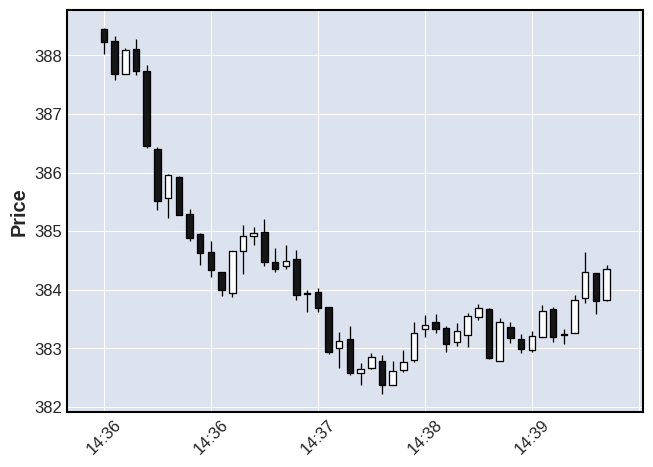

In [79]:
!pip install mplfinance -q
import mplfinance as mpf

df = spy
df.index = pd.DatetimeIndex(df['date'])

mpf.plot(df['2022-11-02 14:36':'2022-11-02 14:39'],type='candle')

Since the speech causing the downmove happens few seconds prior, get the speech in that time frame

In [80]:
spy[50:70]

,date,open,high,low,close,volume,average,barCount,text,percent
date,,,,,,,,,,
2022-11-02 14:35:25,2022-11-02 14:35:25,386.91,387.24,386.88,387.19,24625.0,387.125,181,And we are continuing the process of signific...,0.072368
2022-11-02 14:35:30,2022-11-02 14:35:30,387.21,387.81,387.20,387.77,97840.0,387.514,688,NaN,0.144624
2022-11-02 14:35:35,2022-11-02 14:35:35,387.73,387.93,387.63,387.65,95192.0,387.808,475,"With today's action, we've raised interest ra...",-0.020633
2022-11-02 14:35:40,2022-11-02 14:35:40,387.64,387.76,387.52,387.55,30898.0,387.617,162,We anticipate that ongoing increases in the t...,-0.023217
2022-11-02 14:35:45,2022-11-02 14:35:45,387.56,388.19,387.56,388.16,148005.0,388.015,823,NaN,0.154815
2022-11-02 14:35:50,2022-11-02 14:35:50,388.15,388.63,388.14,388.22,154486.0,388.446,883,NaN,0.018034
2022-11-02 14:35:55,2022-11-02 14:35:55,388.25,388.46,388.02,388.42,51105.0,388.253,320,Financial conditions have tightened significa...,0.043786
2022-11-02 14:36:00,2022-11-02 14:36:00,388.46,388.47,388.02,388.23,61893.0,388.204,368,NaN,-0.059208
2022-11-02 14:36:05,2022-11-02 14:36:05,388.24,388.34,387.58,387.69,93311.0,387.940,520,"It will take time, however, for the full effe...",-0.141665


In [81]:
# TODO: Summarize the speech causing the biggest downfall, using ChatGPT